In [1]:
# On utilise %pip pour cibler le bon environnement Python
# On ajoute --user pour éviter l'erreur "Accès refusé"

print("⏳ Installation de PyTorch (version CUDA)...")
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu122 --user

print("⏳ Installation des outils d'image...")
%pip install opencv-python pillow numpy matplotlib tqdm --user

print("⏳ Installation de Transformers et Hugging Face...")
%pip install transformers huggingface-hub peft accelerate --user
%pip install tensorboard

print("✅ Installation terminée. VEUILLEZ REDÉMARRER LE KERNEL.")

⏳ Installation de PyTorch (version CUDA)...
Looking in indexes: https://download.pytorch.org/whl/cu122
Note: you may need to restart the kernel to use updated packages.
⏳ Installation des outils d'image...


ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision


Note: you may need to restart the kernel to use updated packages.
⏳ Installation de Transformers et Hugging Face...



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.
✅ Installation terminée. VEUILLEZ REDÉMARRER LE KERNEL.




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from PIL import Image
import io
from pathlib import Path
import os
import torch
import matplotlib.pyplot as plt
import random
from peft import LoraConfig, get_peft_model, TaskType

C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
print("✅ Import réussi !")

✅ Import réussi !


Preparation de l'env


In [4]:
def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf"):
    """
    Charge le modèle Depth Anything V2 pré-entraîné et son processeur d'images
    """
    print(f"📥 Chargement du modèle: {model_name}")

    image_processor = AutoImageProcessor.from_pretrained(model_name)
    base_model = AutoModelForDepthEstimation.from_pretrained(model_name)

    print(f"✅ Modèle chargé avec succès")
    return base_model, image_processor

In [5]:
base_model, image_processor = load_pretrained_model()

📥 Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Modèle chargé avec succès


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

In [7]:
# Count parameters
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

📊 Total parameters: 24,785,089
📊 Trainable parameters: 24,785,089


In [8]:
# ===================================================
# INSPECT MODEL ARCHITECTURE
# ===================================================
print("🔍 Inspecting model architecture...")
print("\n" + "="*60)

# Print all module names
print("MODEL STRUCTURE:")
for name, module in base_model.named_modules():
    print(f"  {name}: {module.__class__.__name__}")

print("\n" + "="*60)
print("TRAINABLE LAYERS (before LoRA):")
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")

🔍 Inspecting model architecture...

MODEL STRUCTURE:
  : DepthAnythingForDepthEstimation
  backbone: Dinov2Backbone
  backbone.embeddings: Dinov2Embeddings
  backbone.embeddings.patch_embeddings: Dinov2PatchEmbeddings
  backbone.embeddings.patch_embeddings.projection: Conv2d
  backbone.embeddings.dropout: Dropout
  backbone.encoder: Dinov2Encoder
  backbone.encoder.layer: ModuleList
  backbone.encoder.layer.0: Dinov2Layer
  backbone.encoder.layer.0.norm1: LayerNorm
  backbone.encoder.layer.0.attention: Dinov2Attention
  backbone.encoder.layer.0.attention.attention: Dinov2SelfAttention
  backbone.encoder.layer.0.attention.attention.query: Linear
  backbone.encoder.layer.0.attention.attention.key: Linear
  backbone.encoder.layer.0.attention.attention.value: Linear
  backbone.encoder.layer.0.attention.output: Dinov2SelfOutput
  backbone.encoder.layer.0.attention.output.dense: Linear
  backbone.encoder.layer.0.attention.output.dropout: Dropout
  backbone.encoder.layer.0.layer_scale1: Dinov

PREPARATION  des données

In [11]:

path_images = r"C:/Users/abchikhi/Downloads/DATASET_DEVOIR (1)/DATASET_DEVOIR/images"
path_depths = r"C:/Users/abchikhi/Downloads/DATASET_DEVOIR (1)/DATASET_DEVOIR/depth"

In [12]:
print(f"📂 Dossier Images visé : {path_images}")
print(f"📂 Dossier Depth visé  : {path_depths}")

# Vérification que les dossiers existent
if os.path.exists(path_images) and os.path.exists(path_depths):
    print("\n✅ Les dossiers existent !")
    
    # Compter les fichiers pour être sûr
    nb_img = len([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
    nb_npy = len([f for f in os.listdir(path_depths) if f.endswith('.npy')])
    
    print(f"   -> Trouvé {nb_img} images")
    print(f"   -> Trouvé {nb_npy} fichiers XYZ (.npy)")
else:
    print("\n❌ ERREUR : Un des chemins est introuvable.")
    print("   Vérifie l'orthographe ou copie le chemin absolu.")

📂 Dossier Images visé : C:/Users/abchikhi/Downloads/DATASET_DEVOIR (1)/DATASET_DEVOIR/images
📂 Dossier Depth visé  : C:/Users/abchikhi/Downloads/DATASET_DEVOIR (1)/DATASET_DEVOIR/depth

✅ Les dossiers existent !
   -> Trouvé 58 images
   -> Trouvé 58 fichiers XYZ (.npy)


In [13]:
# 2. COMPTAGE ET LISTING
# ==========================================
print("🔍 Démarrage de la vérification...")

# On liste et on trie pour garantir l'ordre
# On ne garde que les fichiers (pas les dossiers cachés)
files_img = sorted([f for f in os.listdir(path_images) if f.endswith(('.png', '.jpg'))])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

num_img = len(files_img)
num_npy = len(files_npy)

print(f"📊 Bilan comptable :")
print(f"   - Images (.png/.jpg) : {num_img}")
print(f"   - Depths (.npy)      : {num_npy}")

🔍 Démarrage de la vérification...
📊 Bilan comptable :
   - Images (.png/.jpg) : 58
   - Depths (.npy)      : 58


In [14]:
# ==========================================
# 3. VÉRIFICATION DE L'ALIGNEMENT
# ==========================================
if num_img != num_npy:
    print(f"❌ ATTENTION : Le nombre de fichiers ne correspond pas ! (Différence : {abs(num_img - num_npy)})")
else:
    print("✅ Le nombre de fichiers est identique.")

# Vérification des correspondances de noms (optionnel mais recommandé)
# On vérifie si image_01_color.png a bien son équivalent image_01_rawDepth.npy
mismatches = []
for img_name in files_img:
    # On recrée le nom attendu du fichier depth (selon la logique Zivid vue dans ton notebook)
    # Ex: "scan_color.png" -> "scan_rawDepth.npy"
    expected_depth_name = img_name.replace("_color.png", "_rawDepth.npy").replace(".png", ".npy")
    
    # Si tes fichiers n'ont pas "_color", ajuste cette ligne (ex: replace(".png", ".npy"))
    
    if expected_depth_name not in files_npy:
        mismatches.append((img_name, expected_depth_name))

if len(mismatches) > 0:
    print(f"⚠️ ATTENTION : {len(mismatches)} paires ne correspondent pas au niveau du nom !")
    print(f"   Exemple de manquant : {mismatches[0]}")
else:
    print("✅ Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).")

✅ Le nombre de fichiers est identique.
✅ Tous les noms de fichiers semblent correspondre (logique color <-> rawDepth).


In [15]:
# ==========================================
# 4. TEST D'EXTRACTION DU Z (Le fameux Z)
# ==========================================

if num_npy > 0:
    print("\n🧪 Test d'extraction du canal Z sur un fichier aléatoire...")
    
    # Prendre un fichier au hasard
    random_npy = random.choice(files_npy)
    full_path = os.path.join(path_depths, random_npy)
    
    try:
        # Chargement
        data = np.load(full_path) # Shape (H, W, 3) normalement
        
        print(f"   Fichier : {random_npy}")
        print(f"   Shape originale : {data.shape}")
        
        if len(data.shape) == 3 and data.shape[2] == 3:
            # EXTRACTION DU Z (Canal index 2)
            Z_channel = data[:, :, 2]
            
            # Vérif statistiques
            print(f"   ✅ Extraction Z réussie ! Shape finale : {Z_channel.shape}")
            print(f"   Val Min (avec NaN) : {np.nanmin(Z_channel)}")
            print(f"   Val Max (avec NaN) : {np.nanmax(Z_channel)}")
            
            # Vérification des NaN
            nan_count = np.isnan(Z_channel).sum()
            print(f"   Nombre de pixels NaN (vides) : {nan_count} ({(nan_count/Z_channel.size)*100:.1f}%)")
        else:
            print("❌ Erreur : Le fichier .npy n'a pas 3 canaux (XYZ). Vérifie le format.")
            
    except Exception as e:
        print(f"❌ Erreur lors du chargement : {e}")


🧪 Test d'extraction du canal Z sur un fichier aléatoire...
   Fichier : 21-12-03-18-52-30_Zivid_acquisition_rawDepth.npy
   Shape originale : (1200, 1944, 3)
   ✅ Extraction Z réussie ! Shape finale : (1200, 1944)
   Val Min (avec NaN) : 1061.2291259765625
   Val Max (avec NaN) : 2193.236572265625
   Nombre de pixels NaN (vides) : 566671 (24.3%)


In [16]:
filename = "21-12-03-19-05-46_Zivid_acquisition_rawDepth.npy"
full_path = os.path.join(path_depths, filename)

# --- EXTRACTION ---
# 1. Chargement de la donnée (1200, 1944, 3)
data_xyz = np.load(full_path)

# 2. Extraction de la carte de profondeur Z (1200, 1944)
Z_channel = data_xyz[:, :, 2] 

# 3. Traitement des NaN (pour s'assurer qu'on peut lire)
Z_clean = np.nan_to_num(Z_channel, nan=0.0)

# --- LECTURE DE LA VALEUR D'UN PIXEL ---
pixel_row = 600
pixel_col = 972

# Accéder à la valeur Z du pixel (600, 972)
profondeur_pixel = Z_clean[pixel_row, pixel_col]

print(f"Le fichier chargé est de forme : {Z_channel.shape}")
print(f"La valeur de Profondeur (Z) au pixel [{pixel_row}, {pixel_col}] est :")
print(f"-> **{profondeur_pixel:.2f} mm**")

Le fichier chargé est de forme : (1200, 1944)
La valeur de Profondeur (Z) au pixel [600, 972] est :
-> **1365.02 mm**


Nous avons choisi de traiter les données (extraire le canal Z et remplacer les NaN par 0.0) dans la fonction __getitem__ de la classe Dataset (c'est-à-dire pendant l'entraînement) au lieu de le faire une seule fois en amont.1. Efficacité et Économie de Stockage (Le Plus Important) le jeu de données est lourd, et l'objectif est d'éviter de créer des doublons :Données Brutes : Chaque fichier .npy stocke 3 canaux (X, Y, Z).Données Cible : Nous n'avons besoin que d'1 canal (Z).Si nous avions extrait Z et créé un nouveau fichier .npy pour chaque image :Vous auriez doublé le nombre de fichiers sur votre disque dur (un dossier images, un dossier depth_xyz, et un nouveau dossier depth_z_seul).Bien que le fichier de profondeur Z soit plus petit que le fichier XYZ, on aurait passé un temps considérable à générer et stocker des milliers de nouveaux fichiers.En faisant l'opération à la volée, le processus est : Lire le fichier original (XYZ) . Extraire Z en mémoire RAM .Transférer vers le GPU. Aucune duplication n'est nécessaire sur le disque.

Configuration de LoRA


In [17]:

# --- 3. DÉFINITION DE LA CONFIGURATION LoRA ---

# Pour les Vision Transformers, nous ciblons les couches d'attention (Query, Key, Value)
lora_config = LoraConfig(
    r=16,                                    # Le rang de la matrice LoRA (ajustement de la capacité d'apprentissage)
    lora_alpha=32,                           # Facteur de mise à l'échelle (généralement 2 * r)
    target_modules=["query", "key", "value"],# Les couches spécifiques du ViT à modifier (Attention)
    lora_dropout=0.05,                       # Dropout appliqué aux couches LoRA
    bias="none",                             # Ne pas adapter les biais
)

In [18]:
# La fonction get_peft_model gèle les poids du modèle de base et ajoute les adaptateurs LoRA
model_lora = get_peft_model(base_model, lora_config)

print("✅ Modèle LoRA appliqué !")
# Afficher le nombre de paramètres entraînés
model_lora.print_trainable_parameters()

✅ Modèle LoRA appliqué !
trainable params: 442,368 || all params: 25,227,457 || trainable%: 1.7535


In [34]:
def depth_data_collator(features):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in features]),
        "labels": torch.stack([x["labels"] for x in features]),
        "valid_mask": torch.stack([x["valid_mask"] for x in features]),
    }


In [35]:
# ===================================================
# CALCUL DES STATISTIQUES GLOBALES DU DATASET
# ===================================================
print("📊 Calcul des statistiques sur TOUS les fichiers depth...")
print("   (Cela peut prendre quelques minutes...)\n")

depth_stats = {
    'min_values': [],
    'max_values': [],
    'mean_values': [],
    'valid_percentages': []
}

# Parcourir TOUS les fichiers .npy
from tqdm import tqdm  # Pour une barre de progression

for depth_file in tqdm(files_npy, desc="Analyse des fichiers depth"):
    depth_path = os.path.join(path_depths, depth_file)
    
    # Charger et extraire Z
    depth_xyz = np.load(depth_path)
    depth_z = depth_xyz[:, :, 2]
    
    # Calculer statistiques (en ignorant NaN)
    if not np.all(np.isnan(depth_z)):  # Si au moins une valeur valide
        depth_stats['min_values'].append(np.nanmin(depth_z))
        depth_stats['max_values'].append(np.nanmax(depth_z))
        depth_stats['mean_values'].append(np.nanmean(depth_z))
        
        # % de pixels valides
        valid_pct = (~np.isnan(depth_z)).sum() / depth_z.size * 100
        depth_stats['valid_percentages'].append(valid_pct)

# Calculer les statistiques globales
GLOBAL_MIN = np.min(depth_stats['min_values'])
GLOBAL_MAX = np.max(depth_stats['max_values'])
GLOBAL_MEAN = np.mean(depth_stats['mean_values'])
GLOBAL_STD = np.std(depth_stats['mean_values'])

print("\n" + "="*60)
print("STATISTIQUES GLOBALES DU DATASET")
print("="*60)
print(f"📏 Profondeur MIN (sur tous les fichiers): {GLOBAL_MIN:.2f} mm")
print(f"📏 Profondeur MAX (sur tous les fichiers): {GLOBAL_MAX:.2f} mm")
print(f"📊 Moyenne des moyennes: {GLOBAL_MEAN:.2f} mm")
print(f"📊 Écart-type: {GLOBAL_STD:.2f} mm")
print(f"✅ Pixels valides (moyenne): {np.mean(depth_stats['valid_percentages']):.1f}%")
print("="*60)

# Ces valeurs vont servir pour la normalisation!
print(f"\n💡 Utilisez ces valeurs dans votre Dataset:")
print(f"   depth_min = {GLOBAL_MIN:.2f}")
print(f"   depth_max = {GLOBAL_MAX:.2f}")

📊 Calcul des statistiques sur TOUS les fichiers depth...
   (Cela peut prendre quelques minutes...)



Analyse des fichiers depth: 100%|██████████| 58/58 [00:02<00:00, 23.50it/s]


STATISTIQUES GLOBALES DU DATASET
📏 Profondeur MIN (sur tous les fichiers): 251.74 mm
📏 Profondeur MAX (sur tous les fichiers): 3907.45 mm
📊 Moyenne des moyennes: 1542.16 mm
📊 Écart-type: 295.35 mm
✅ Pixels valides (moyenne): 68.5%

💡 Utilisez ces valeurs dans votre Dataset:
   depth_min = 251.74
   depth_max = 3907.45


In [36]:
# Analyse des données image par image
print(f"Analyse de {len(files_npy)} fichiers .npy pixel par pixel...")

# Initialisation des compteurs globaux
total_nan_global = 0
total_zero_global = 0
total_inf_global = 0
total_pixels_analyses = 0

rapport_erreurs = {}

for filename in files_npy:
    full_path = os.path.join(path_depths, filename)
    
    try:
        data = np.load(full_path)
        total_pixels_analyses += data.size
        
        # Détection par type
        num_nan = np.count_nonzero(np.isnan(data))
        num_zero = np.count_nonzero(data == 0)
        num_inf = np.count_nonzero(np.isinf(data))
        
        # Somme des manquants pour ce fichier précis
        total_manquants_file = num_nan + num_zero + num_inf

        # Mise à jour des compteurs globaux
        total_nan_global += num_nan
        total_zero_global += num_zero
        total_inf_global += num_inf

        if total_manquants_file > 0:
            # On stocke les détails pour le rapport final
            rapport_erreurs[filename] = {
                "nan": num_nan, 
                "zero": num_zero, 
                "inf": num_inf, 
                "total": total_manquants_file,
                "shape": data.shape
            }
            # Affichage immédiat pour suivre l'avancement
            print(f"⚠️ {filename} : {total_manquants_file} valeurs manquantes détectées")

    except Exception as e:
        print(f"❌ Erreur lecture {filename}: {e}")

# --- Résumé final détaillé ---
print("\n" + "="*50)
print("📊 BILAN DÉTAILLÉ PAR IMAGE")
print("="*50)

if not rapport_erreurs:
    print("✨ Félicitations ! Aucun pixel manquant sur l'ensemble du dataset.")
else:
    # On trie les erreurs pour afficher les fichiers les plus problématiques en premier
    fichiers_tries = sorted(rapport_erreurs.items(), key=lambda x: x[1]['total'], reverse=True)
    
    for filename, stats in fichiers_tries:
        print(f"🖼️  {filename :<25} | Total manquants: {stats['total']:<8} (NaN:{stats['nan']}, 0:{stats['zero']})")

    print("\n" + "="*50)
    print("📈 STATISTIQUES GLOBALES")
    print("-" * 50)
    total_anomalies = total_nan_global + total_zero_global + total_inf_global
    print(f"✅ Total pixels analysés : {total_pixels_analyses:,}")
    print(f"❌ Total valeurs manquantes : {total_anomalies:,}")
    
    if total_pixels_analyses > 0:
        pourcentage = (total_anomalies / total_pixels_analyses) * 100
        print(f"⚠️ Taux de corruption global : {pourcentage:.4f}%")
    print(f"📂 Nombre de fichiers affectés : {len(rapport_erreurs)} / {len(files_npy)}")

Analyse de 58 fichiers .npy pixel par pixel...
⚠️ 21-12-03-18-50-31_Zivid_acquisition_rawDepth.npy : 2116980 valeurs manquantes détectées
⚠️ 21-12-03-18-50-34_Zivid_acquisition_rawDepth.npy : 1730646 valeurs manquantes détectées
⚠️ 21-12-03-18-50-37_Zivid_acquisition_rawDepth.npy : 1655943 valeurs manquantes détectées
⚠️ 21-12-03-18-50-39_Zivid_acquisition_rawDepth.npy : 2033433 valeurs manquantes détectées
⚠️ 21-12-03-18-50-55_Zivid_acquisition_rawDepth.npy : 2366760 valeurs manquantes détectées
⚠️ 21-12-03-18-52-27_Zivid_acquisition_rawDepth.npy : 1982451 valeurs manquantes détectées
⚠️ 21-12-03-18-52-30_Zivid_acquisition_rawDepth.npy : 1700013 valeurs manquantes détectées
⚠️ 21-12-03-18-52-32_Zivid_acquisition_rawDepth.npy : 2108175 valeurs manquantes détectées
⚠️ 21-12-03-18-52-35_Zivid_acquisition_rawDepth.npy : 1727091 valeurs manquantes détectées
⚠️ 21-12-03-18-52-37_Zivid_acquisition_rawDepth.npy : 1658802 valeurs manquantes détectées
⚠️ 21-12-03-18-52-40_Zivid_acquisition_rawD

In [45]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF


class ZividDepthDataset(Dataset):
    def __init__(self, image_folder, depth_folder, image_files, depth_files,
                 processor, depth_min, depth_max, use_inverse=True, augment=False):

        self.image_folder = image_folder
        self.depth_folder = depth_folder
        self.image_files = image_files
        self.depth_files = depth_files
        self.processor = processor
        self.depth_min = depth_min
        self.depth_max = depth_max
        self.use_inverse = use_inverse
        self.augment = augment

        # Résolution utilisée par Depth Anything
        self.target_size = (756, 1260)   # multiple de 14 (ViT)


    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):

        # ===============================
        # 1. Load image & depth
        # ===============================
        img = Image.open(os.path.join(self.image_folder, self.image_files[idx])).convert("RGB")
        xyz = np.load(os.path.join(self.depth_folder, self.depth_files[idx]))

        depth = xyz[..., 2] if xyz.ndim == 3 else xyz
        depth = np.nan_to_num(depth, nan=0.0)

        # ===============================
        # 2. Resize (same geometry)
        # ===============================
        img = TF.resize(img, self.target_size)

        depth = Image.fromarray(depth.astype(np.float32))
        depth = TF.resize(depth, self.target_size)
        depth = np.array(depth)

        # ===============================
        # 3. Validity mask (after resize!)
        # ===============================
        valid_mask = (depth > 0) & (depth < 10000)

        # ===============================
        # 4. Data augmentation
        # ===============================
        if self.augment:
            if random.random() > 0.5:
                img = TF.hflip(img)
                depth = np.fliplr(depth)
                valid_mask = np.fliplr(valid_mask)

            if random.random() > 0.5:
                img = TF.vflip(img)
                depth = np.flipud(depth)
                valid_mask = np.flipud(valid_mask)

        # ===============================
        # 5. Depth normalization
        # ===============================
        if self.use_inverse:
            depth_inv = 1.0 / (depth + 1e-6)
            dmin = 1.0 / self.depth_max
            dmax = 1.0 / self.depth_min
            depth_norm = (depth_inv - dmin) / (dmax - dmin + 1e-6)
        else:
            depth_norm = (depth - self.depth_min) / (self.depth_max - self.depth_min + 1e-6)

        depth_norm = np.clip(depth_norm, 0.0, 1.0)

        # ===============================
        # 6. Depth Anything processor
        # ===============================
        inputs = self.processor(images=img, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze(0)

        # ===============================
        # 7. To torch tensors
        # ===============================
        depth_norm = torch.from_numpy(depth_norm).float()
        valid_mask = torch.from_numpy(valid_mask).float()

        return {
            "pixel_values": pixel_values,
            "labels": depth_norm,
            "valid_mask": valid_mask
        }


In [46]:
from transformers import Trainer
import torch.nn.functional as F
import torch
class DepthTrainerFinal(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        pixel_values = inputs["pixel_values"]
        labels = inputs["labels"]
        mask = inputs.get("valid_mask", None)
        
        # Inférence
        outputs = model(pixel_values=pixel_values)
        pred = outputs.predicted_depth
        
        # 1. Mise à l'échelle (Bicubic pour préserver les courbes des pneus)
        # On passe de la résolution interne (ex: 756x1260) à la résolution du label (1200x1944)
        pred = F.interpolate(
            pred.unsqueeze(1), 
            size=labels.shape[-2:], 
            mode="bicubic", 
            align_corners=False
        ).squeeze(1)
        
        # 2. Masquage des zones valides (évite d'apprendre sur les NaN/vides)
        valid_mask = (mask > 0) & (labels > 0)
        
        # 3. Perte L1 (Précision globale de la distance)
        l1_loss = F.l1_loss(pred[valid_mask], labels[valid_mask])
        
        # 4. Perte de Gradient (Netteté des contours)
        def get_grad(x):
            # Calcule la différence entre pixels adjacents
            dx = x[:, :, 1:] - x[:, :, :-1]
            dy = x[:, 1:, :] - x[:, :-1, :]
            return dx, dy

        pdx, pdy = get_grad(pred)
        gdx, gdy = get_grad(labels)
        
        # Masques pour les gradients (les deux pixels voisins doivent être valides)
        mask_x = valid_mask[:, :, 1:] * valid_mask[:, :, :-1]
        mask_y = valid_mask[:, 1:, :] * valid_mask[:, :-1, :]

        # Poids : On multiplie par 10 l'importance des pixels qui sont des bords (fort gradient)
        weight_x = 1.0 + 10.0 * (torch.abs(gdx) > 0.02).float() 
        weight_y = 1.0 + 10.0 * (torch.abs(gdy) > 0.02).float()
        
        # Somme des erreurs de gradient normalisée par le nombre de pixels valides
        grad_loss_x = (torch.abs(pdx - gdx) * weight_x * mask_x).sum() / (mask_x.sum() + 1e-6)
        grad_loss_y = (torch.abs(pdy - gdy) * weight_y * mask_y).sum() / (mask_y.sum() + 1e-6)
        
        grad_loss = grad_loss_x + grad_loss_y
        
        # 5. PERTE TOTALE pondérée
        loss = l1_loss + 3.0 * grad_loss
        
        # Retour indispensable pour le Trainer de HuggingFace
        return (loss, outputs) if return_outputs else loss

In [47]:
# ===================================================
# SPLIT TRAIN / VALIDATION
# ===================================================
from sklearn.model_selection import train_test_split

# Vos fichiers déjà triés
files_img = sorted([f for f in os.listdir(path_images) if f.endswith('.png')])
files_npy = sorted([f for f in os.listdir(path_depths) if f.endswith('.npy')])

print(f" Total de fichiers: {len(files_img)}")

# Split 80% train, 20% validation
train_imgs, val_imgs, train_depths, val_depths = train_test_split(
    files_img, files_npy, 
    test_size=0.2,  # 20% validation
    random_state=42,  # Pour reproductibilité
    shuffle=True
)

print(f" Split effectué:")
print(f"   Train: {len(train_imgs)} échantillons")
print(f"   Val:   {len(val_imgs)} échantillons")

 Total de fichiers: 58
 Split effectué:
   Train: 46 échantillons
   Val:   12 échantillons


In [ ]:
# ===================================================
# CELLULE DE SAUVETAGE : INSTANCIATION & TRAINER
# ===================================================
from transformers import TrainingArguments
import torch

# 1. On recrée les Datasets pour être SÛR qu'ils existent et sont bien configurés
# Important : use_inverse=False pour la métrologie (mesure précise en mm)
train_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=train_imgs,
    depth_files=train_depths,
    processor=image_processor,
    depth_min=GLOBAL_MIN,
    depth_max=GLOBAL_MAX,
    use_inverse=True
)

val_dataset = ZividDepthDataset(
    image_folder=path_images,
    depth_folder=path_depths,
    image_files=val_imgs,
    depth_files=val_depths,
    processor=image_processor,
    depth_min=GLOBAL_MIN,
    depth_max=GLOBAL_MAX,
    use_inverse=True
)

# 2. Nettoyage VRAM
torch.cuda.empty_cache()

# 3. Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./resultats_pneu_v5",
    learning_rate=5e-5,
    num_train_epochs=15,
    per_device_train_batch_size=1,      # Indispensable pour la haute résolution
    gradient_accumulation_steps=8,      # Simule un batch de 8
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    remove_unused_columns=False,
    dataloader_num_workers=0,
    report_to="none"
)

# 4. Initialisation du Trainer
trainer = DepthTrainerFinal(
    model=model_lora,                   # On utilise bien 'model_lora'
    args=training_args,
    train_dataset=train_dataset,        # On utilise les variables créées juste au-dessus
    eval_dataset=val_dataset,
    data_collator=depth_data_collator,
)

🔨 Création des Datasets (Mode Linéaire pour Pneus)...


In [57]:


def compute_depth_metrics(pred, gt, mask):
    pred = pred[mask]
    gt   = gt[mask]

    eps = 1e-6
    pred = torch.clamp(pred, min=eps)
    gt   = torch.clamp(gt, min=eps)

    # Ratio
    ratio = torch.max(pred / gt, gt / pred)

    # Delta metrics
    delta1 = (ratio < 1.25).float().mean()
    delta2 = (ratio < 1.25**2).float().mean()
    delta3 = (ratio < 1.25**3).float().mean()

    # Errors
    abs_rel = torch.mean(torch.abs(pred - gt) / gt)
    rmse = torch.sqrt(torch.mean((pred - gt) ** 2))
    log_rmse = torch.sqrt(torch.mean((torch.log(pred) - torch.log(gt)) ** 2))

    return {
        "abs_rel": abs_rel.item(),
        "rmse": rmse.item(),
        "log_rmse": log_rmse.item(),
        "delta1": delta1.item(),
        "delta2": delta2.item(),
        "delta3": delta3.item(),
    }


In [58]:
import torch.nn.functional as F

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    preds = torch.tensor(preds)
    labels = torch.tensor(labels)

    # Upscale preds to GT resolution
    preds = F.interpolate(
        preds.unsqueeze(1),
        size=labels.shape[-2:],
        mode="bicubic",
        align_corners=False
    ).squeeze(1)

    # Valid mask
    mask = labels > 0

    return compute_depth_metrics(preds, labels, mask)


In [59]:
trainer = DepthTrainerFinal(
    model=model_lora,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=depth_data_collator,
    compute_metrics=compute_metrics
)


In [60]:
print("\n🚀 Démarrage de l'entraînement...\n")
trainer.train()



🚀 Démarrage de l'entraînement...



C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\abchikhi\AppData\Roaming\Python\Python310\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\abc

TrainOutput(global_step=90, training_loss=1.8932442559136284, metrics={'train_runtime': 2521.3235, 'train_samples_per_second': 0.274, 'train_steps_per_second': 0.036, 'total_flos': 1.4087844696700656e+17, 'train_loss': 1.8932442559136284, 'epoch': 15.0})

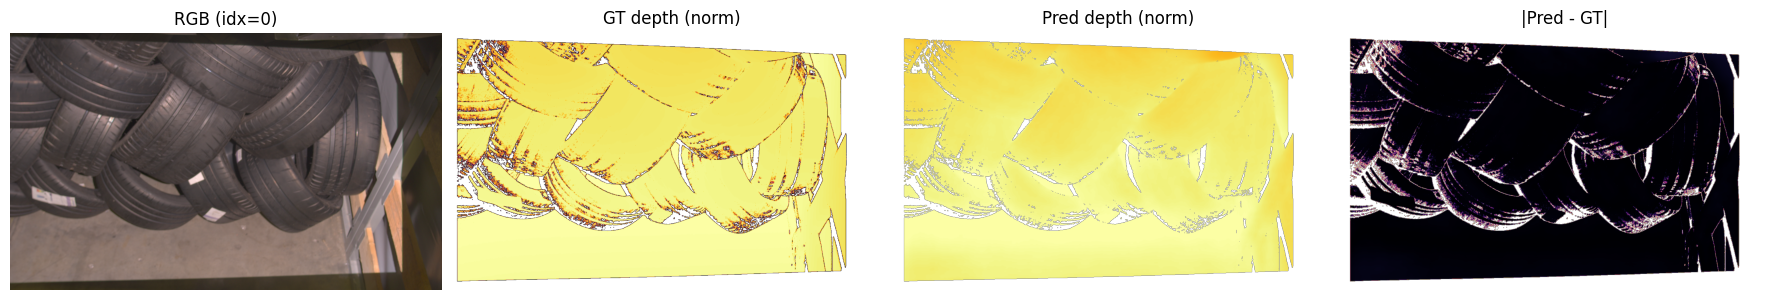

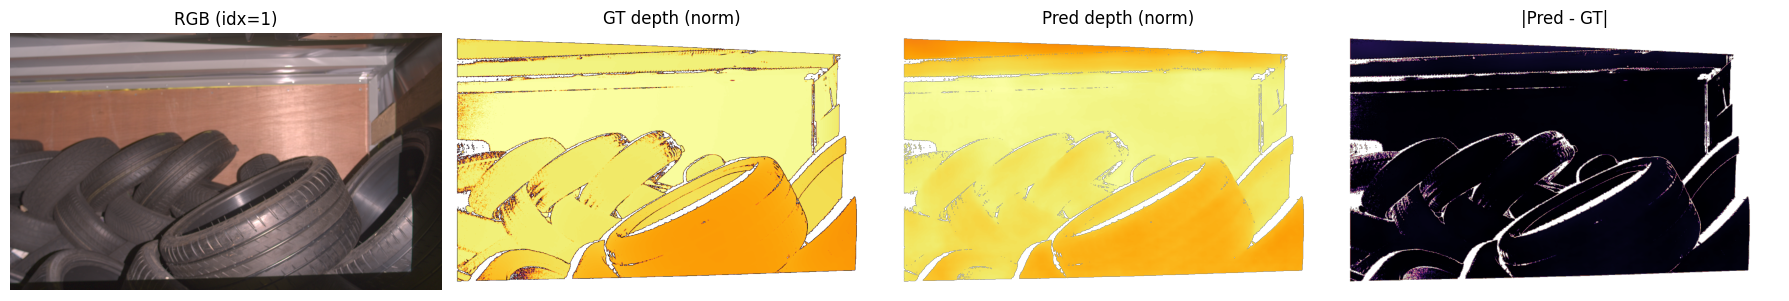

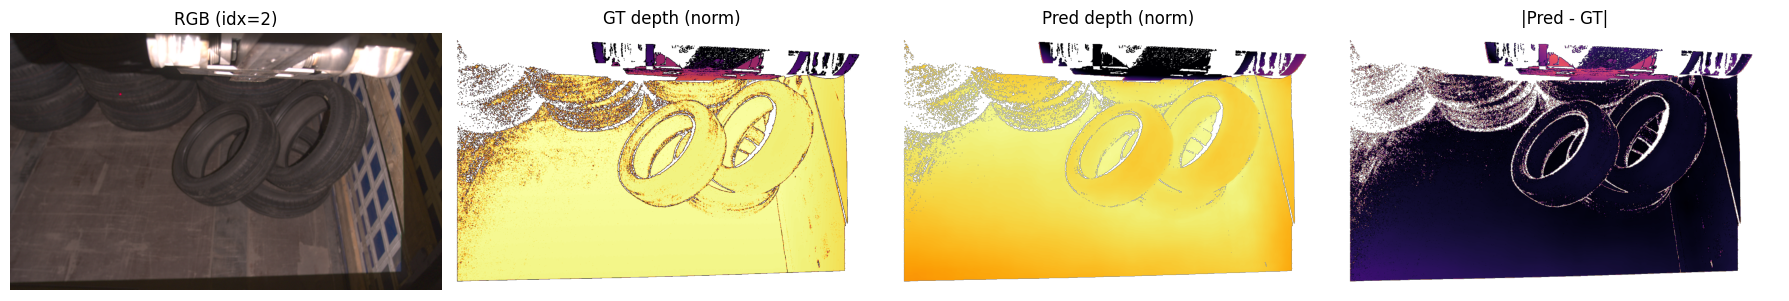

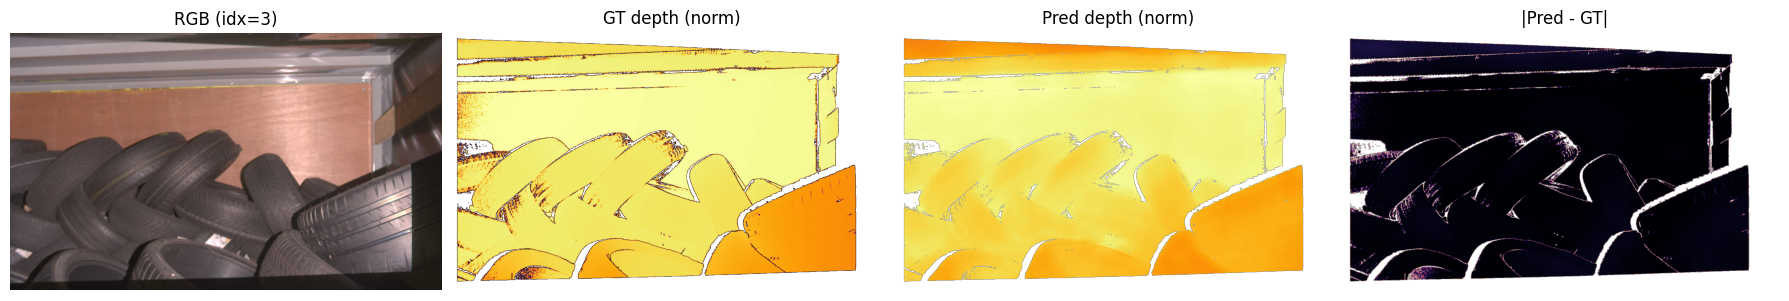

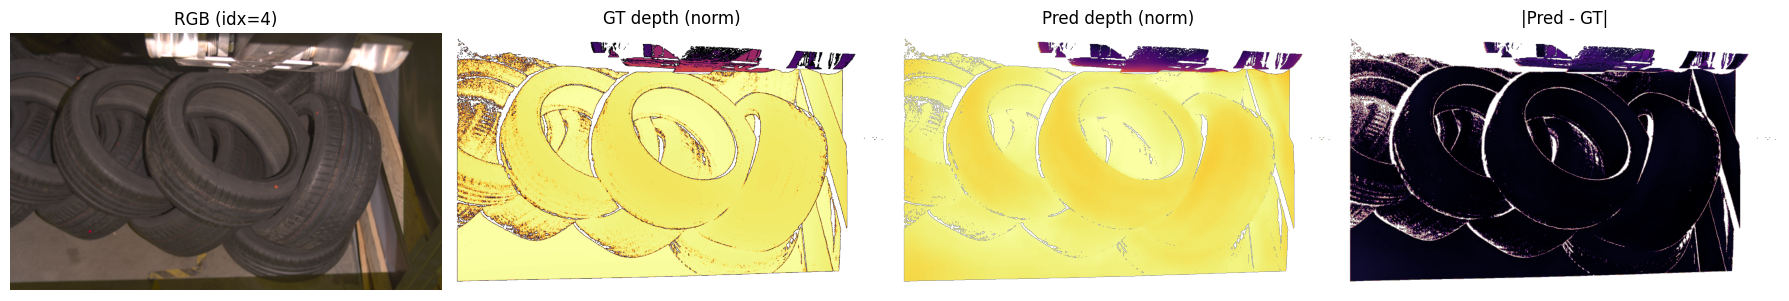

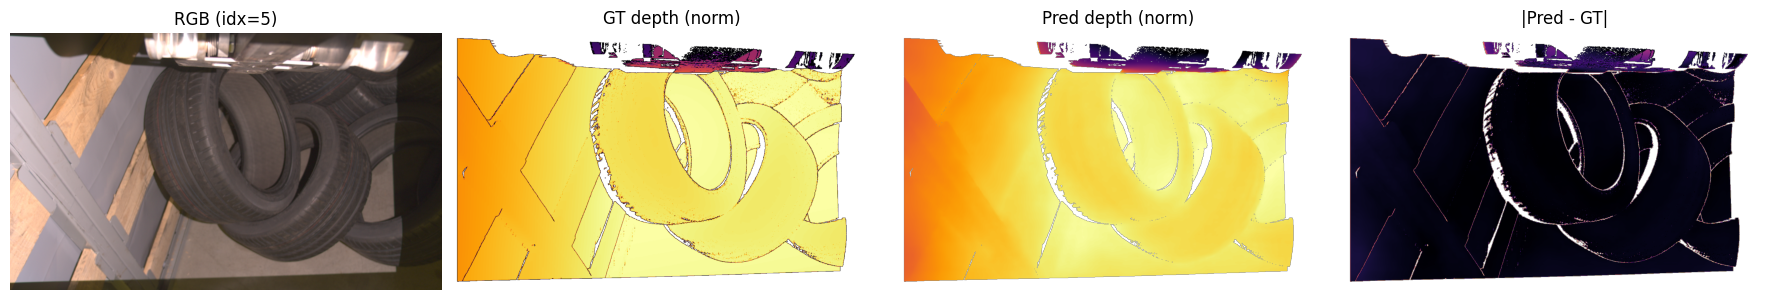

In [64]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_rgb(x):
    x = x.cpu()
    x = x * IMAGENET_STD + IMAGENET_MEAN
    x = torch.clamp(x, 0, 1)
    return x.permute(1,2,0).numpy()

@torch.no_grad()
def show_prediction_cpu(model, dataset, idx=0, cmap_depth="inferno_r", cmap_err="magma"):
    model.eval()
    model.to("cpu")

    sample = dataset[idx]
    pixel_values = sample["pixel_values"].unsqueeze(0)   # CPU
    labels = sample["labels"]
    valid_mask = sample["valid_mask"] > 0

    out = model(pixel_values=pixel_values)
    pred = out.predicted_depth  # (1,h,w)

    pred = F.interpolate(
        pred.unsqueeze(1),
        size=labels.shape[-2:],
        mode="bicubic",
        align_corners=False
    ).squeeze(1).squeeze(0).cpu()

    gt = labels.cpu()

    # masquer invalides (NaN)
    gt_vis = gt.clone()
    pred_vis = pred.clone()
    gt_vis[~valid_mask] = float("nan")
    pred_vis[~valid_mask] = float("nan")

    # échelle commune pour GT/Pred
    vmin = np.nanpercentile(gt_vis.numpy(), 2)
    vmax = np.nanpercentile(gt_vis.numpy(), 98)

    err = torch.abs(pred_vis - gt_vis)

    rgb = denorm_rgb(sample["pixel_values"])

    plt.figure(figsize=(18,5))
    plt.subplot(1,4,1); plt.title(f"RGB (idx={idx})"); plt.imshow(rgb); plt.axis("off")
    plt.subplot(1,4,2); plt.title("GT depth (norm)"); plt.imshow(gt_vis, cmap=cmap_depth, vmin=vmin, vmax=vmax); plt.axis("off")
    plt.subplot(1,4,3); plt.title("Pred depth (norm)"); plt.imshow(pred_vis, cmap=cmap_depth, vmin=vmin, vmax=vmax); plt.axis("off")
    plt.subplot(1,4,4); plt.title("|Pred - GT|"); plt.imshow(err, cmap=cmap_err); plt.axis("off")
    plt.tight_layout()
    plt.show()

# Exemple
for i in [0, 1, 2,3,4,5]:
    show_prediction_cpu(model_lora, val_dataset, idx=i, cmap_depth="inferno_r")


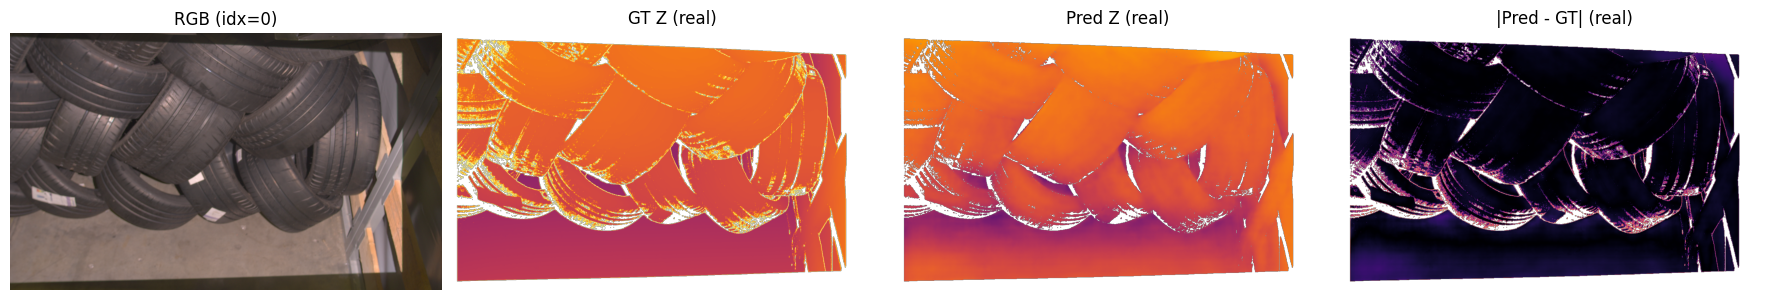

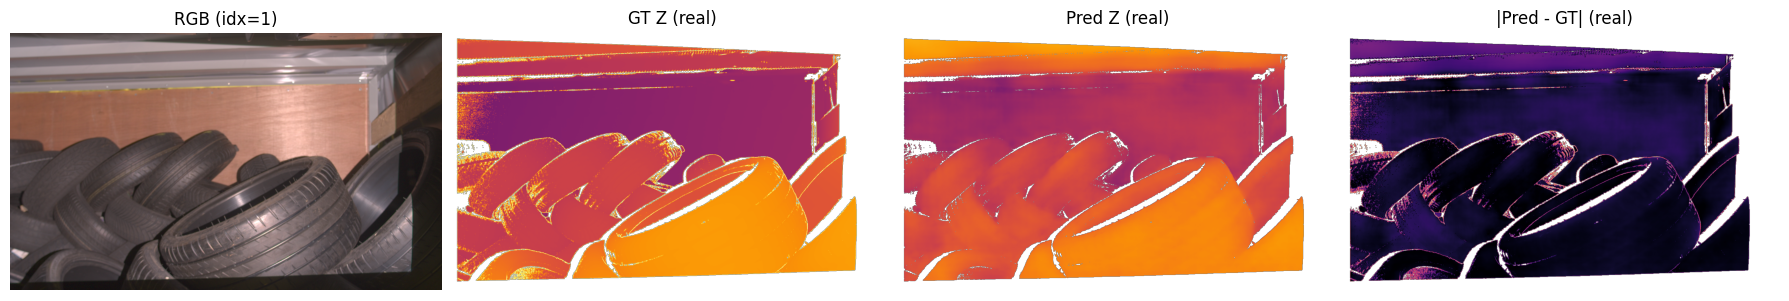

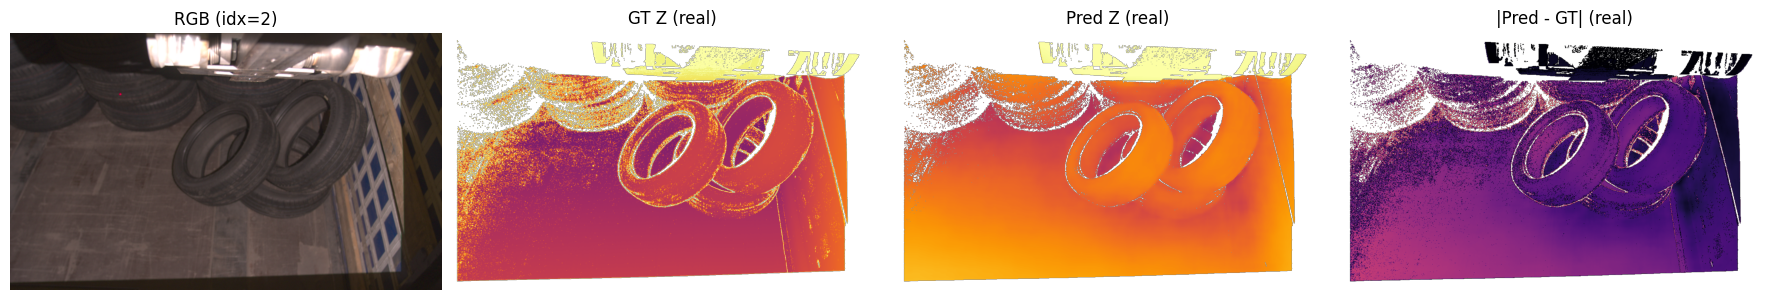

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---- Params (à adapter si besoin) ----
DEPTH_MIN = GLOBAL_MIN   # ex: en mm ou en m (doit être cohérent)
DEPTH_MAX = GLOBAL_MAX
USE_INVERSE = True       # chez toi : True

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_rgb(x):
    x = x.cpu()
    x = x * IMAGENET_STD + IMAGENET_MEAN
    x = torch.clamp(x, 0, 1)
    return x.permute(1,2,0).numpy()

def denorm_to_Z(depth_norm, depth_min, depth_max, use_inverse=True):
    """Convertit depth_norm (0..1) -> Z réel (mm ou m selon tes GLOBAL_MIN/MAX)."""
    eps = 1e-6
    depth_norm = torch.clamp(depth_norm, 0.0, 1.0)

    if use_inverse:
        dmin = 1.0 / (depth_max + eps)
        dmax = 1.0 / (depth_min + eps)
        inv = depth_norm * (dmax - dmin) + dmin
        Z = 1.0 / (inv + eps)
    else:
        Z = depth_norm * (depth_max - depth_min) + depth_min

    return Z

@torch.no_grad()
def show_prediction_real_scale(model, dataset, idx=0, vmin=None, vmax=None, cmap="inferno_r"):
    model.eval()
    model.to("cpu")

    sample = dataset[idx]
    pixel_values = sample["pixel_values"].unsqueeze(0)   # CPU
    labels_norm = sample["labels"]                       # (H,W) norm 0..1
    valid_mask = (sample["valid_mask"] > 0)              # (H,W)

    out = model(pixel_values=pixel_values)
    pred_norm = out.predicted_depth                      # (1,h,w)

    # Upsample -> résolution labels
    pred_norm = F.interpolate(
        pred_norm.unsqueeze(1),
        size=labels_norm.shape[-2:],
        mode="bicubic",
        align_corners=False
    ).squeeze(1).squeeze(0).cpu()

    # Dé-normalisation -> Z réel
    Z_gt = denorm_to_Z(labels_norm.cpu(), DEPTH_MIN, DEPTH_MAX, USE_INVERSE)
    Z_pred = denorm_to_Z(pred_norm, DEPTH_MIN, DEPTH_MAX, USE_INVERSE)

    # Masquer invalides
    Z_gt_vis = Z_gt.clone()
    Z_pred_vis = Z_pred.clone()
    Z_gt_vis[~valid_mask] = float("nan")
    Z_pred_vis[~valid_mask] = float("nan")

    # Échelle absolue fixée (si non fournie -> utilise min/max globaux)
    if vmin is None: vmin = DEPTH_MIN
    if vmax is None: vmax = DEPTH_MAX

    # Erreur absolue en unités réelles
    err = torch.abs(Z_pred_vis - Z_gt_vis)

    rgb = denorm_rgb(sample["pixel_values"])

    plt.figure(figsize=(18,5))
    plt.subplot(1,4,1); plt.title(f"RGB (idx={idx})"); plt.imshow(rgb); plt.axis("off")
    plt.subplot(1,4,2); plt.title(f"GT Z (real)"); plt.imshow(Z_gt_vis, cmap=cmap, vmin=vmin, vmax=vmax); plt.axis("off")
    plt.subplot(1,4,3); plt.title(f"Pred Z (real)"); plt.imshow(Z_pred_vis, cmap=cmap, vmin=vmin, vmax=vmax); plt.axis("off")
    plt.subplot(1,4,4); plt.title("|Pred - GT| (real)"); plt.imshow(err, cmap="magma"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# afficher 3 images en échelle réelle (fixée GLOBAL_MIN..GLOBAL_MAX)
for i in [0, 1, 2]:
    show_prediction_real_scale(model_lora, val_dataset, idx=i)


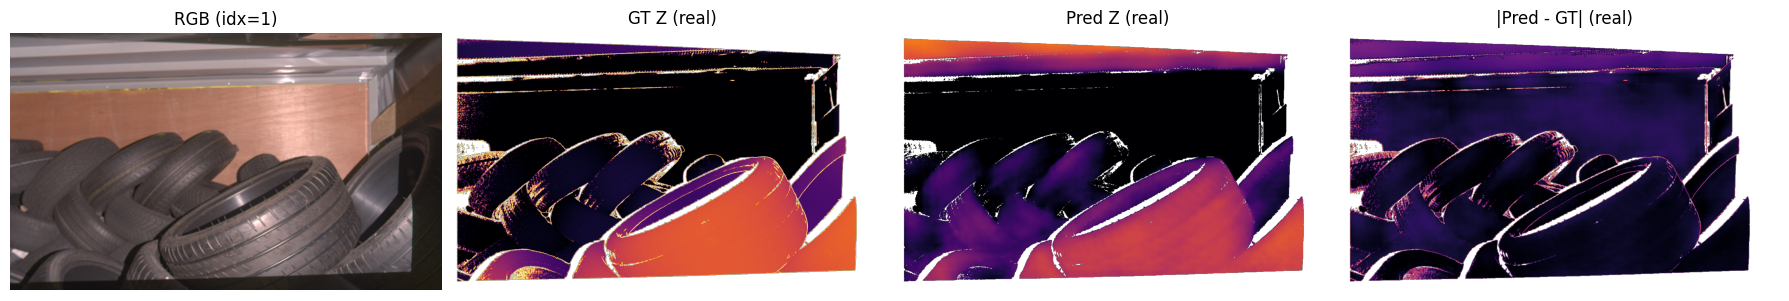

In [66]:
show_prediction_real_scale(model_lora, val_dataset, idx=1, vmin=500, vmax=2000)
